In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
sys.path.insert(0, '../src/')

In [2]:
from general_utilies import autoscale_y, exp_df_dict_loader
from pnml_utilities import get_argmax_prediction, get_mean_prediction, predictor_using_mdl
from pnml_utilities import predictor_using_taylor
fig = plt.figure()
figsize = fig.get_size_inches()

<Figure size 432x288 with 0 Axes>

In [3]:
# Load dataset
base_dir = '../output/vanilla_results_20190504_183157'
base_dir = '../output/vanilla_results_20190505_095317'

# Load from pickle
regret_df = pd.read_pickle(os.path.join(base_dir, 'regret_df.pkl'))
# with open(os.path.join(base_dir, 'exp_df_dict.pkl'), 'rb') as handle:
#     exp_df_dict = pickle.load(handle)
exp_df_dict = exp_df_dict_loader(base_dir)
with open(os.path.join(base_dir, 'trainset_dict.pkl'), 'rb') as handle:
    trainset_dict = pickle.load(handle)
x_train = trainset_dict['x_train']
y_train = trainset_dict['y_train']
x_test = regret_df.index.tolist()

print('Train set: ', x_train)
print('Test set: {} to {}'.format(x_test[0], x_test[-1]))

Train set:  [-0.2, 0.1, 0.4]
Test set: -0.3 to 0.99


In [4]:
# Check if valid
for key, exp_df in exp_df_dict.items():
    y_values = exp_df.index.values
    dy = abs((y_values[:-1] - y_values[1:]).mean())
    print('Sum result for ', key)

    for x in exp_df:
        if abs(dy*exp_df[x].sum() - 1.0) > 1e-6:
            print('    The sum for {} is {}'.format(x, dy*exp_df[x].sum()))

Sum result for  1
Sum result for  2
Sum result for  Twice


In [5]:
# Get argmax predictor
print('argmax predictor')
start_time = time.time()
argmax_prediction_dict = get_argmax_prediction(exp_df_dict)
print('Finished argmax predictor in {}'.format(time.time()-start_time))

# Get mean predictor
print('mean predictor')
start_time = time.time()
mean_prediction_dict = get_mean_prediction(exp_df_dict)
print('Finished mean predictor in {}'.format(time.time()-start_time))

print('min MDL')
start_time = time.time()
min_mdl_prediction, regret_mdl = predictor_using_mdl(
    exp_df_dict, regret_df, mean_prediction_dict)
print('Finished MDL predictor in {}'.format(time.time()-start_time))

print('min Taylor')
start_time = time.time()
min_taylor_prediction, regret_taylor = predictor_using_taylor(
    exp_df_dict, regret_df, mean_prediction_dict)
print('Finished Taylor predictor in {}'.format(time.time()-start_time))

argmax predictor
Finished argmax predictor in 2.0497000217437744
mean predictor
Finished mean predictor in 5.342387914657593
min MDL
Finished MDL predictor in 0.8251190185546875
min Taylor
Finished Taylor predictor in 0.6520528793334961


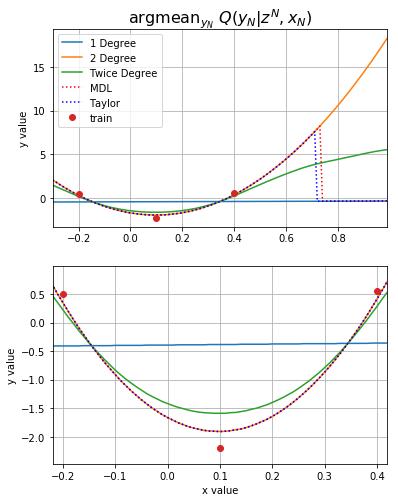

In [6]:
# Plot mean prediction
prediction_dict = argmax_prediction_dict
prediction_dict = mean_prediction_dict
fig, axs = plt.subplots(2, 1, facecolor='w',
                        figsize=(figsize[0], figsize[1]*2))
for ax in axs:
    for poly_degree, prediction in prediction_dict.items():
        ax.plot(prediction.index.astype(float), prediction.values,
                label='%s Degree' % poly_degree)
    ax.plot(min_mdl_prediction.index.astype(float), min_mdl_prediction.values, ':',
            label='MDL', color='red')
    ax.plot(min_taylor_prediction.index.astype(float), min_taylor_prediction.values, ':',
            label='Taylor', color='b')
    ax.set_ylabel('y value')
    ax.grid(True)
    ax.plot(x_train, y_train, 'o', label='train')
axs[0].set_xlim(x_test[0], x_test[-1])
axs[1].set_xlim(x_train[0]-0.02, x_train[-1]+0.02)
autoscale_y(axs[1])
axs[1].set_xlabel('x value')
axs[0].set_title(r"argmean$_{y_N}$ $Q(y_N|z^N,x_N)$", fontsize=16)
axs[0].legend()
plt.savefig('../output/figures/linear_regression_argmean.pdf',
            dpi=300, bbox_inches='tight')
plt.show()

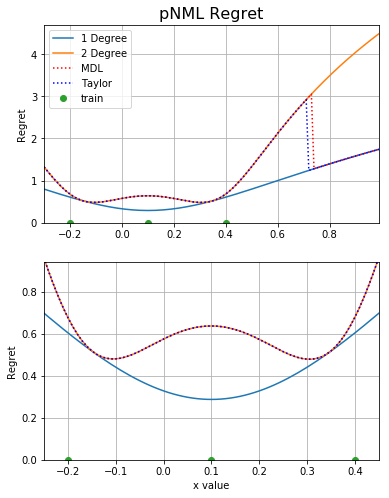

In [7]:
# Regret plot
fig, axs = plt.subplots(len(regret_df.columns), 1,
                        facecolor='w', figsize=(figsize[0], figsize[1]*2))
for ax in axs:
    for poly_degree, regret in regret_df.iteritems():
        ax.plot(regret.index, regret.values,
                label='%s Degree' % poly_degree)
    ax.plot(regret_mdl.index, regret_mdl.values, ':', label='MDL', color='red')
    ax.plot(regret_taylor.index, regret_taylor.values,
            ':', label='Taylor', color='b')
    ax.set_ylabel('Regret')
    ax.set_ylim(bottom=0.0)
    ax.grid(True)
    ax.plot(x_train, [0] * len(x_train), 'o', label='train')
axs[0].set_xlim(x_test[0], x_test[-1])
axs[1].set_xlim(x_train[0]-0.05, x_train[-1]+0.05)
autoscale_y(axs[1])
axs[1].set_xlabel('x value')
axs[0].set_title('pNML Regret', fontsize=16)
axs[0].legend()
plt.savefig('../output/figures/linear_regression_regret.pdf',
            dpi=300, bbox_inches='tight')
plt.show()

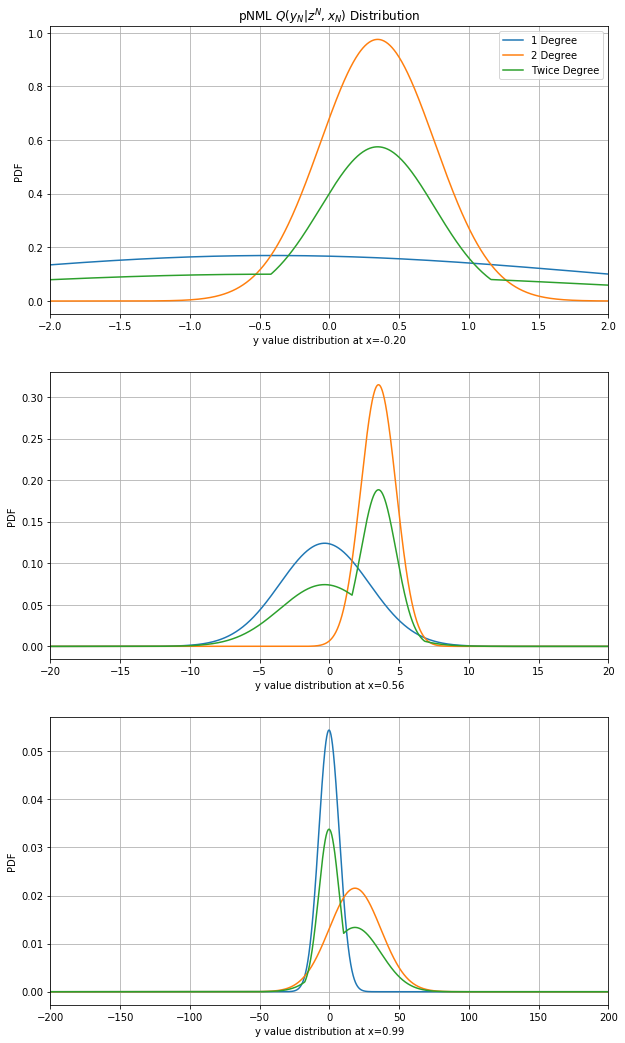

In [8]:
# Plot distribution
plot_num = 3
x_val_to_plot_list = x_test[::int(len(x_test)/plot_num)][1:]
x_val_to_plot_list[0] = -0.2  # see prediction in the train set
x_lim_diff_list = [2, 20, 200]

fig_width, fig_height = 10, plot_num*6
fig, axs = plt.subplots(plot_num, 1,
                        facecolor='w',
                        figsize=(fig_width, fig_height))
for ax, x_val_to_plot, x_lim_diff in zip(axs, x_val_to_plot_list, x_lim_diff_list):
    for poly_degree, exp_df in exp_df_dict.items():
        ax.plot(exp_df.index, exp_df[str(x_val_to_plot)].values,
                label='%s Degree' % poly_degree)
    ax.set_xlabel('y value distribution at x={:.2f}'.format(x_val_to_plot))
    ax.set_xlim(- x_lim_diff, x_lim_diff)
    ax.set_ylabel('PDF')
    ax.grid(True)
axs[0].legend()
axs[0].set_title(r'pNML $Q(y_N|z^N,x_N)$ Distribution')
fig.subplots_adjust()
plt.show()